This notebook implements regression on the first round results with cross validation.

## Pipeline

- Data pre-processing: run codes/data_generating.py
- Reading data: read data/firstRound_4h.csv into pandas dataframe
- Cross validation: training (training, validating); testing, KFold (K = ?)
    - Emdedding
        - Onehot
        - Label 
    - Kernel
        - RBF
        - DotProduct
        - Spectrum 
            - lmer: l = ?
            - Padding_flag: add special characters before and after sequences, e.g. 'ACTGAA' -> 'ZZ' + 'ACTGAA' + 'ZZ'
            - gap_flag:add gapped features, e.g. 3-mer-1-gap
            - normalised_kernel: e.g. zero-mean, unit-norm, unit-var
        - Sum of Spectrum
            - a K_A + b K_B + c K_C, where a + b + c = 1
    - Regression model
        - Gaussian process regression 
            - alpha: scalar value add to diagonal 
            - heteroscedastic: noises are learned as well (same as normalise each replicates to have same derivatives)
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

## Splitting in terms of sequences vs samples?

For each sequence, we have at least three biological replicates. There are two ways splitting data into training and testing data: splitting in terms of sequences, where if one sequence is split into the training dataset, then all replicates of that sequences belong to the training dataset; splitting in terms of samples, where the replicates of one sequence can be in the training or testing dataset. The two methods both make sense in terms of the evaluation of Gaussian process regression.

Considering the goal is to design good sequences for the second round experiment, we expect for training, we do not have any information about the sequences in the testing dataset. That is, splitting in terms of sequences can better simulate the sequence design task. 

In this notebook, we show both two methods of splitting data. We expect that splitting in terms of samples provide a lower error in testing data since the model may have seen the sequences. The test error of splitting sequences should have higher variance, since the prediction depends on whether the sequences in test dataset similar to the sequences in the training dataset. But again, our goal is to decrease the test error as well as the variance for the case of splitting sequences. 

## Evaluate on samples vs sample mean?

For training, we use the samples as labels, since we model the label for each sequence as samples from a unknown (Gaussian) reward distribution.

For testing, we use the sample mean for the sequence (i.e. mean value of the three replicates) as label. The ideal label should be the true mean of underlying distribution (we assume is Gaussian) of a sequence, however, we do not know the true mean. The only choice is to use the sample mean to approximate the true mean, which has the risk the sample mean would deviate a lot from the true mean since the number of samples is quite low (and variance of samples is not low). 

## Choices to make within cross validation 

- alpha: scalar value add to diagonal 
- kernel
- lmer: l = ?
- For Sum_Spectrum_Kernel: b for (1 - b)/2 K_A + b K_B + (1-b)/2 K_C

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
#from codes.regression import Regression
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
from sklearn.model_selection import KFold

def Train_test_split(num_data, test_size = 0.2, random_state = 24):
    np.random.seed(random_state)
    test_idx = np.random.choice(num_data, int(test_size * num_data), replace=False)
    train_idx = list(set(range(num_data)) - set(test_idx))
    
    return np.asarray(train_idx), np.asarray(test_idx)

def Train_val_split(num_data, cv = 5, random_state = 24):
    kf = KFold(n_splits = cv, shuffle = True)
    return kf.split(range(num_data))

def Generate_train_test_data(df, train_idx, test_idx, embedding):
    if 'Rep1' in df.columns:
        train_df = pd.melt(df.loc[train_idx], id_vars=['RBS', 'RBS6', 'AVERAGE', 'STD', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
        train_df = train_df.dropna()
        train_df = train_df.rename(columns = {'value': 'label'})
        test_df = pd.melt(df.loc[test_idx], id_vars=['RBS', 'RBS6', 'AVERAGE', 'STD', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
        test_df = test_df.dropna()
        test_df = test_df.rename(columns = {'value': 'label'})
    else: 
        train_df = df.loc[train_idx]
        test_df = df.loc[test_idx]
        
    X_train = Rewards_env(np.asarray(train_df[['RBS', 'label']]), embedding).embedded
    y_train_sample = np.asarray(train_df['label'])
    y_train_ave = np.asarray(train_df['AVERAGE'])
    
    X_test = Rewards_env(np.asarray(test_df[['RBS', 'label']]), embedding).embedded
    y_test_sample = np.asarray(test_df['label'])
    y_test_ave = np.asarray(test_df['AVERAGE']) 
    
    return X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import json

# cross validation on training dataset. Find the optimal alpha. 

def cross_val(df, cv = 5, random_state = 24, test_size = 0.2, kernel_list = ['Spectrum_Kernel', 'Sum_Spectrum_Kernel'],
              alpha_list = [0.1, 1], embedding = 'label', eva_metric = r2_score, eva_on_ave_flag = True,
              l_list = [3], b_list = [0.33], weight_flag = False, padding_flag = False, gap_flag = False):
    test_scores = []
    
    data = np.asarray(df[['RBS', 'AVERAGE']])
    num_data = data.shape[0]
    
    train_idx, test_idx = Train_test_split(num_data, test_size, random_state)
    X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave  = Generate_train_test_data(df, train_idx, test_idx, embedding)

    for train_idx, test_idx in Train_val_split(num_data, cv = cv, random_state = random_state):
        X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave  = Generate_train_test_data(df, train_idx, test_idx, embedding)
        cv_scores = {}
        
        ori_b_list = b_list

        for kernel_name in kernel_list:
            
            if kernel_name == 'Spectrum_Kernel':
                b_list = [1]
            else:
                b_list = ori_b_list
                
            for alpha in alpha_list:
                for l_list in l_lists:
                    for b in b_list:
                        scores = []
                        kernel = kernel_dict[kernel_name]
                        b = float(b)

                        if kernel_name == 'Spectrum_Kernel': 
                            gp_reg = GaussianProcessRegressor(kernel = kernel(l_list = l_list, weight_flag = weight_flag, padding_flag = padding_flag, gap_flag = gap_flag), alpha = alpha)
                        elif kernel_name == 'Sum_Spectrum_Kernel':
                            gp_reg = GaussianProcessRegressor(kernel = kernel(l_list = l_list, b = b, weight_flag = weight_flag, padding_flag = padding_flag, gap_flag = gap_flag), alpha = alpha)
                        else: 
                            gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = alpha)

                        for train_train_idx, train_val_idx in Train_val_split(len(train_idx), cv= cv, random_state=random_state):
                            X_train_train, X_train_val, y_train_train_sample, y_train_val_sample, y_train_train_ave, y_train_val_ave  = Generate_train_test_data(df, train_train_idx, train_val_idx, embedding)
                            gp_reg.fit(X_train_train, y_train_train_sample)
                            y_train_val_predict = gp_reg.predict(X_train_val)
                            if eva_on_ave_flag:
                                scores.append(eva_metric(y_train_val_ave, y_train_val_predict)) # evaluate on AVERAGE value
                            else:
                                scores.append(eva_metric(y_train_val_sample, y_train_val_predict)) # evaluate on samples
                        #scores = cross_val_score(gp_reg, X_train, y_train, cv = cv, scoring = make_scorer(eva_metric))
            
                        cv_scores[kernel_name + '-' + str(alpha)+ '-' + json.dumps(l_list) + '-' + str(b)] = np.asarray(scores).mean() 
        
        ax = sns.scatterplot(list(cv_scores.keys()), list(cv_scores.values()), marker = '.')
        ax.set_xticklabels(list(cv_scores.keys()), rotation = 90)
        plt.xlabel('kernel, alpha')
        plt.ylabel(str(eva_metric))
        plt.show()

        if eva_metric == r2_score:
            optimal_kernel, optimal_alpha, optimal_l_list, optimal_b = list(cv_scores.keys())[np.argmax(list(cv_scores.values()))].split('-')
        else:
            optimal_kernel, optimal_alpha, optimal_l_list, optimal_b = list(cv_scores.keys())[np.argmin(list(cv_scores.values()))].split('-')
        optimal_l_list = json.loads(optimal_l_list)
        print('optimal kernel: ', optimal_kernel, ', optimal alpha: ', optimal_alpha, ', optiaml l list: ', optimal_l_list, ', optimal b: ', optimal_b)
        
        optimal_kernel = str(optimal_kernel)
        print(optimal_kernel)
        if optimal_kernel == 'Spectrum_Kernel': 
            print('1')
            gp_reg = GaussianProcessRegressor(kernel = kernel_dict[optimal_kernel](l_list = optimal_l_list, weight_flag = weight_flag, padding_flag = padding_flag, gap_flag = gap_flag), alpha = float(optimal_alpha))
        elif optimal_kernel == 'Sum_Spectrum_Kernel':
            print('2')
            gp_reg = GaussianProcessRegressor(kernel = kernel_dict[optimal_kernel](l_list = optimal_l_list, b = float(optimal_b), weight_flag = weight_flag, padding_flag = padding_flag, gap_flag = gap_flag), alpha = float(optimal_alpha))
        else:
            print('3')
            gp_reg = GaussianProcessRegressor(kernel = kernel_dict[optimal_kernel](), alpha = float(optimal_alpha))
            
        gp_reg.fit(X_train,y_train_sample)
        y_train_pred = gp_reg.predict(X_train)
        y_test_pred= gp_reg.predict(X_test)

        if eva_on_ave_flag:
            print('Train: ', eva_metric(y_train_ave, y_train_pred))
            print('Test: ', eva_metric(y_test_ave, y_test_pred))
            test_scores.append(eva_metric(y_test_ave, y_test_pred))

            plt.scatter(y_train_ave, y_train_pred, label = 'train')
            plt.scatter(y_test_ave, y_test_pred, label = 'test')
            
        else:
            print('Train: ', eva_metric(y_train_sample, y_train_pred))
            print('Test: ', eva_metric(y_test_sample, y_test_pred))
            test_scores.append(eva_metric(y_test_sample, y_test_pred))

            plt.scatter(y_train_sample, y_train_pred, label = 'train')
            plt.scatter(y_test_sample, y_test_pred, label = 'test')
        plt.xlabel('label')
        plt.ylabel('pred')
        plt.legend()
        plt.plot([-2, 3], [-2,3])
        plt.show()
    print('Cross-validation Test mean: ', np.asarray(test_scores).mean())
    print('Cross-validation Test std: ', np.asarray(test_scores).std())
        
    return optimal_alpha, test_scores
        

In [4]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel
}

In [5]:
# setting

cv = 5
test_size = 0.2
random_state = 24
embedding = 'label'
eva_on_ave_flag = True # true label is the sample mean instead of individual samples, since the prediction is the posterior mean
eva_metric = mean_squared_error # mean square error returns a more stable optimal hyparameter choice than r2 score

kernel_list = ['Spectrum_Kernel', 'Sum_Spectrum_Kernel']
alpha_list = [0.1, 1, 2, 3]
l_lists = [[3], [2, 3, 4, 5, 6]]
b_list = [0.33, 0.6, 0.8]

weight_flag = False
padding_flag = False
gap_flag = False

## Cross Validation for sequences

In [6]:
Path = '../../data/firstRound_4h.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6,Change_Pos,Base
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,reference,AGGAGA,1.0,T
1,21,TTTAAGACGGAGATATACAT,RBS_1by1_22,0.636342,0.785468,0.153062,0.524957,0.330589,0.117560,bps_core,CGGAGA,8.0,C
2,22,TTTAAGAGGGAGATATACAT,RBS_1by1_23,-0.616473,-0.502488,0.414480,-0.234827,0.565197,0.043805,bps_core,GGGAGA,8.0,G
3,23,TTTAAGATGGAGATATACAT,RBS_1by1_24,1.249077,0.811791,-0.085595,0.658424,0.680425,0.228128,bps_core,TGGAGA,8.0,T
4,24,TTTAAGAACGAGATATACAT,RBS_1by1_25,1.280146,1.046771,0.953997,1.093638,0.168050,0.193737,bps_core,ACGAGA,9.0,C
5,25,TTTAAGAAAGAGATATACAT,RBS_1by1_26,-0.137300,-0.361841,0.782388,0.094415,0.606287,0.185443,bps_core,AAGAGA,9.0,A
6,26,TTTAAGAATGAGATATACAT,RBS_1by1_27,-0.663860,-0.616878,0.002153,-0.426195,0.371703,0.062400,bps_core,ATGAGA,9.0,T
7,27,TTTAAGAAGCAGATATACAT,RBS_1by1_28,-0.482614,-0.686311,-0.107793,-0.425572,0.293447,0.172987,bps_core,AGCAGA,10.0,C
8,28,TTTAAGAAGAAGATATACAT,RBS_1by1_29,-1.399968,-0.990957,-0.270713,-0.887213,0.571731,0.431229,bps_core,AGAAGA,10.0,A
9,29,TTTAAGAAGTAGATATACAT,RBS_1by1_30,-0.823305,-1.716794,-0.850261,-1.130120,0.508253,0.723149,bps_core,AGTAGA,10.0,T


In [7]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(150, 13)

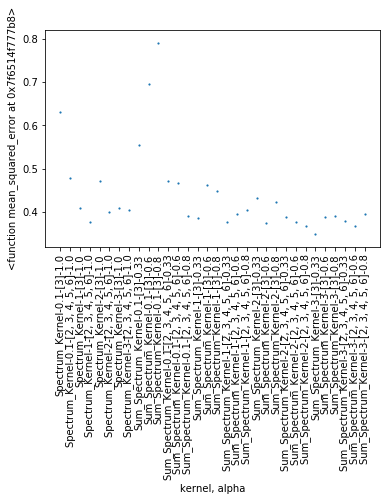

optimal kernel:  Sum_Spectrum_Kernel , optimal alpha:  3 , optiaml l list:  [3] , optimal b:  0.33
Sum_Spectrum_Kernel
2
Train:  0.26676677206193994
Test:  0.5077636102858155


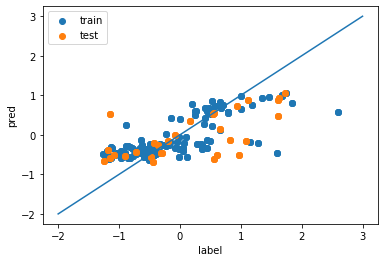

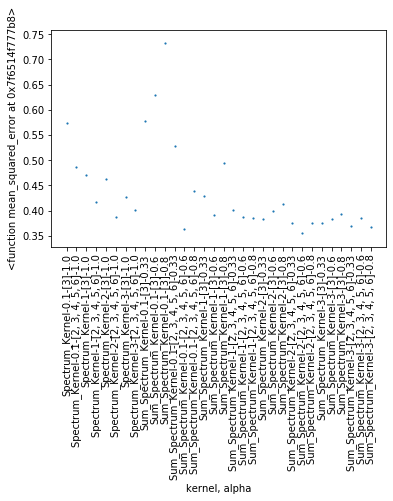

optimal kernel:  Sum_Spectrum_Kernel , optimal alpha:  2 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  0.6
Sum_Spectrum_Kernel
2
Train:  0.22159407942069637
Test:  0.5095803182420111


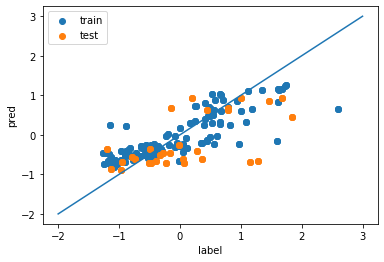

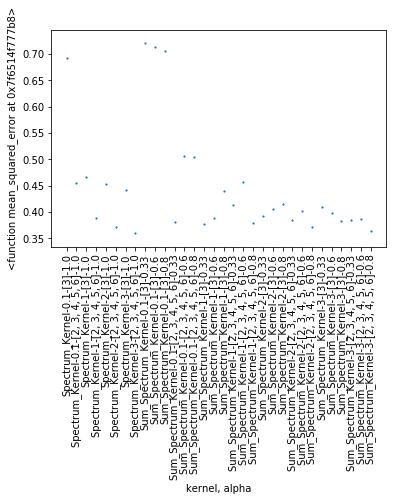

optimal kernel:  Spectrum_Kernel , optimal alpha:  3 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.1804356205306726
Test:  0.3865120800346932


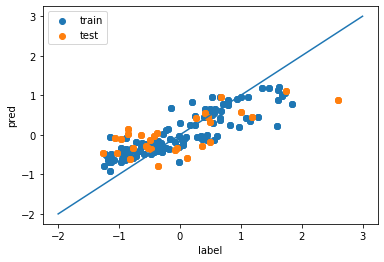

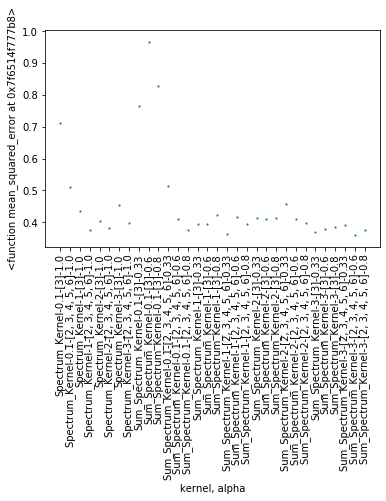

optimal kernel:  Sum_Spectrum_Kernel , optimal alpha:  3 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  0.6
Sum_Spectrum_Kernel
2
Train:  0.2280544679632379
Test:  0.4634054590375734


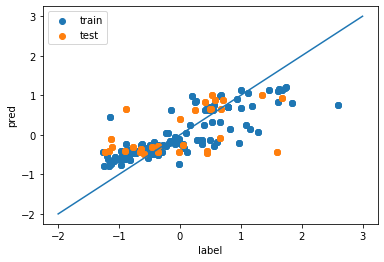

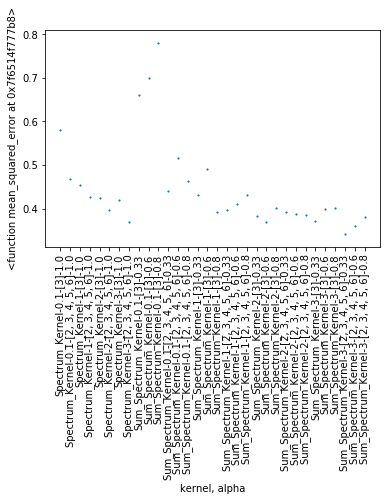

optimal kernel:  Sum_Spectrum_Kernel , optimal alpha:  3 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  0.33
Sum_Spectrum_Kernel
2
Train:  0.304522077580452
Test:  0.18882747309286105


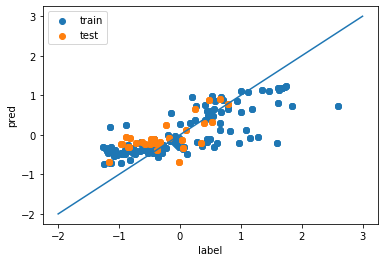

Cross-validation Test mean:  0.41121778813859083
Cross-validation Test std:  0.1198229196233711


In [8]:
optimal_para, test_scores = cross_val(df, cv, random_state, test_size, kernel_list,  alpha_list, embedding, eva_metric, eva_on_ave_flag,
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

## Optimal Choices for splitting sequences case

- optimal kernel:  Spectrum_Kernel , 
- optimal alpha:  2 , 
- optiaml l list:  [2, 3, 4, 5, 6]

## Cross Validation for samples

In [9]:
Path = '../../data/firstRound_4h+Baseline.csv'

df_samples = pd.read_csv(Path)
df_samples.head()

,Unnamed: 0,AVERAGE,Group,RBS,RBS6,STD,label,variable
0,0,2.592357,reference,TTTAAGAAGGAGATATACAT,AGGAGA,0.717515,3.194925,Rep1
1,1,1.604161,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,0.284382,1.844257,Rep1
2,2,0.662662,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.017069,0.674610,Rep1
3,3,1.678999,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,0.500712,1.986839,Rep1
4,4,1.671743,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,0.624388,1.830061,Rep1


In [10]:
df_samples_frr = df_samples[df_samples['Group'] != 'Baseline data'].reindex()

In [11]:
df_samples_frr.shape

(449, 8)

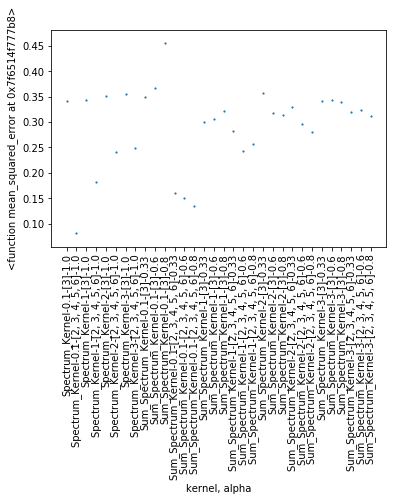

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.038280336511474146
Test:  0.14920095535172687


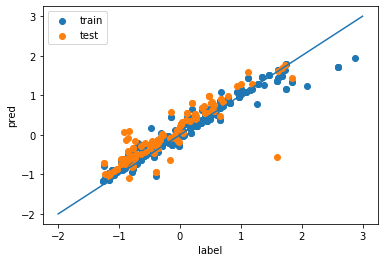

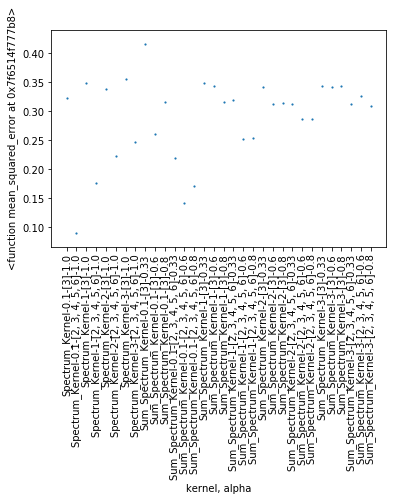

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.05754412382728784
Test:  0.1391310721840107


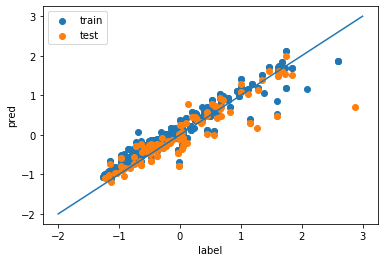

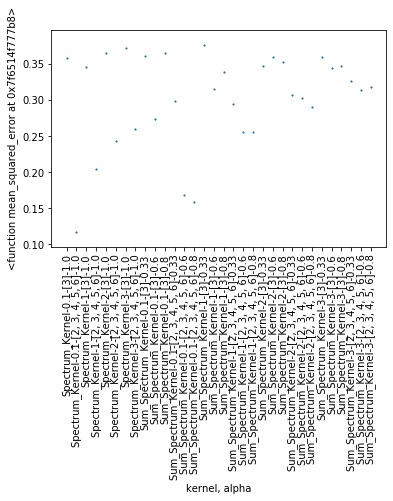

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.04863124354238451
Test:  0.1044470793226757


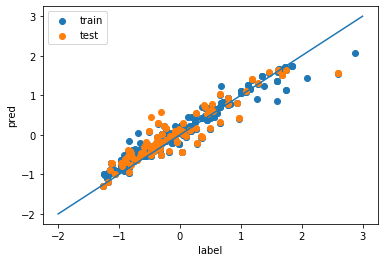

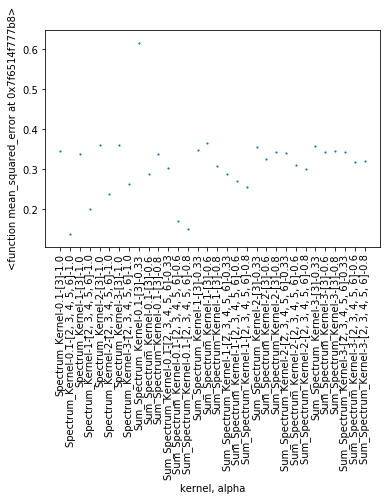

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.050081396436592235
Test:  0.16904875641270303


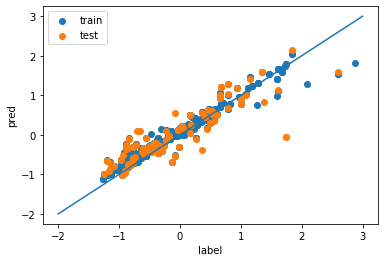

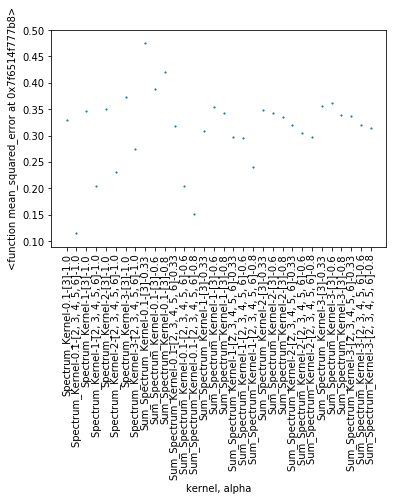

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.04435563284491224
Test:  0.2090937165259646


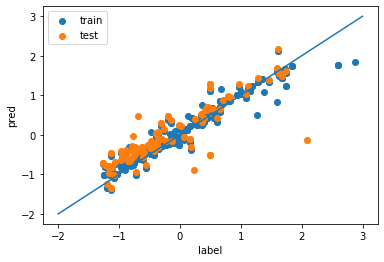

Cross-validation Test mean:  0.1541843159594162
Cross-validation Test std:  0.03452888819505821


In [12]:
optimal_para, test_scores = cross_val(df_samples, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag, 
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

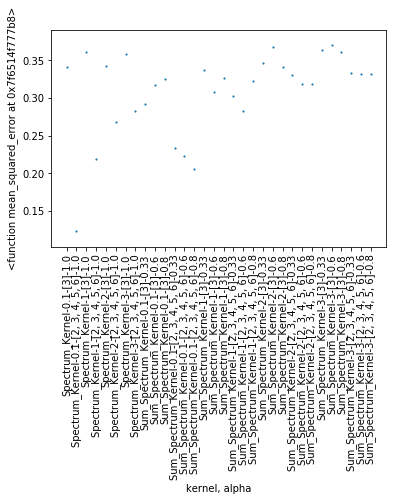

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.03048524316002643
Test:  0.0550995714714543


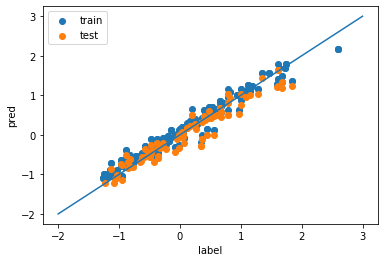

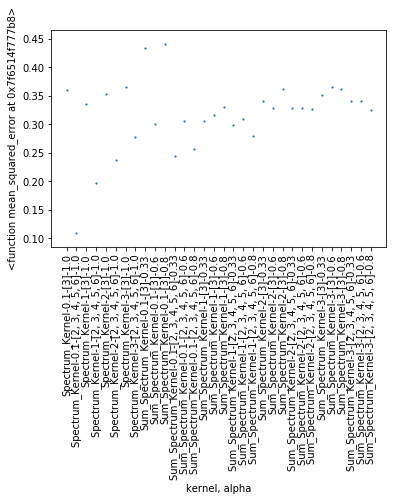

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.021166241709606175
Test:  0.044884628036845946


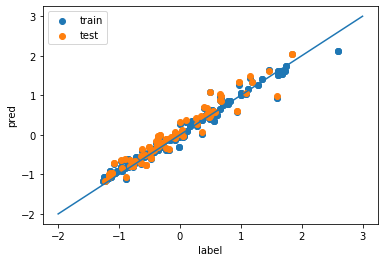

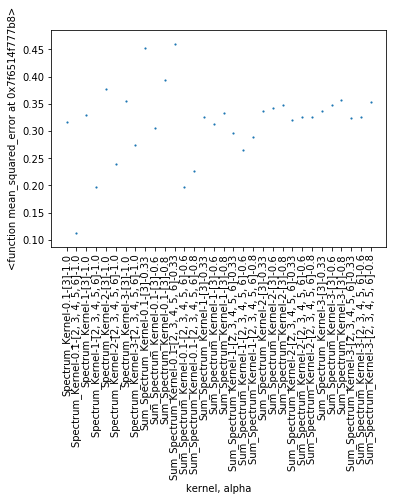

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.017717568846731084
Test:  0.1730620969382828


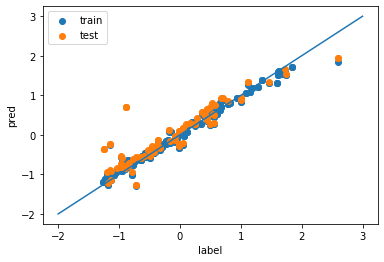

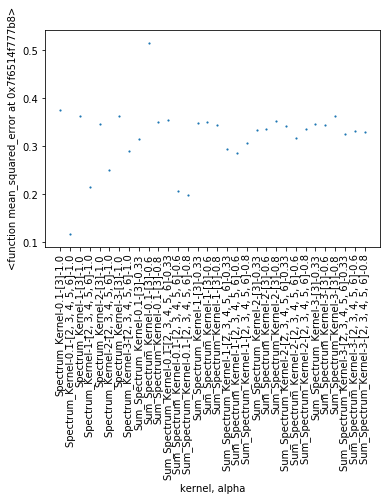

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.026452753336128405
Test:  0.0956794758621775


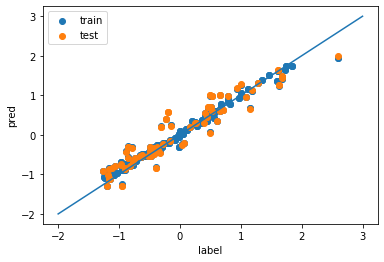

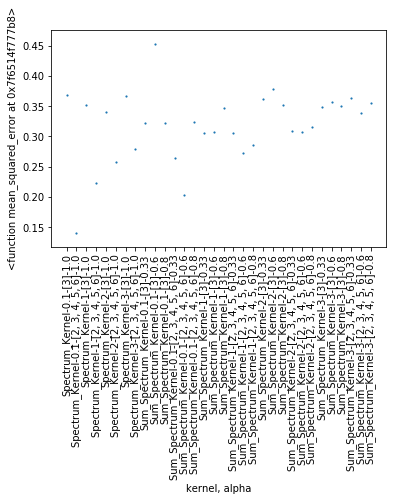

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [2, 3, 4, 5, 6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.02595751297172487
Test:  0.0557005721163639


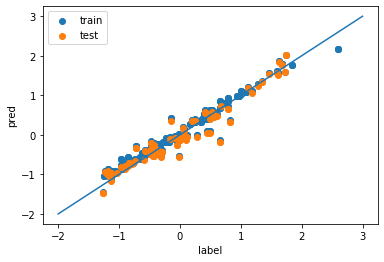

Cross-validation Test mean:  0.0848852688850249
Cross-validation Test std:  0.04739336129450179


In [13]:
optimal_para, test_scores = cross_val(df_samples_frr, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag, 
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

## Optimal Choices for splitting samples case

- optimal kernel:  Spectrum_Kernel , 
- optimal alpha:  0.1 , 
- optiaml l list:  [2, 3, 4, 5, 6]
    
As we expected, when splitting in terms of samples, we have a smaller test error and smaller test error variance as well compared splitting in terms of sequences.

## Normalise replicates?

normalise each replicates to have same derivatives i.e. heteroscedastic noises are learned 

In [14]:
num_data = df.shape[0]
sorted_df = df.sort_values(['AVERAGE'])

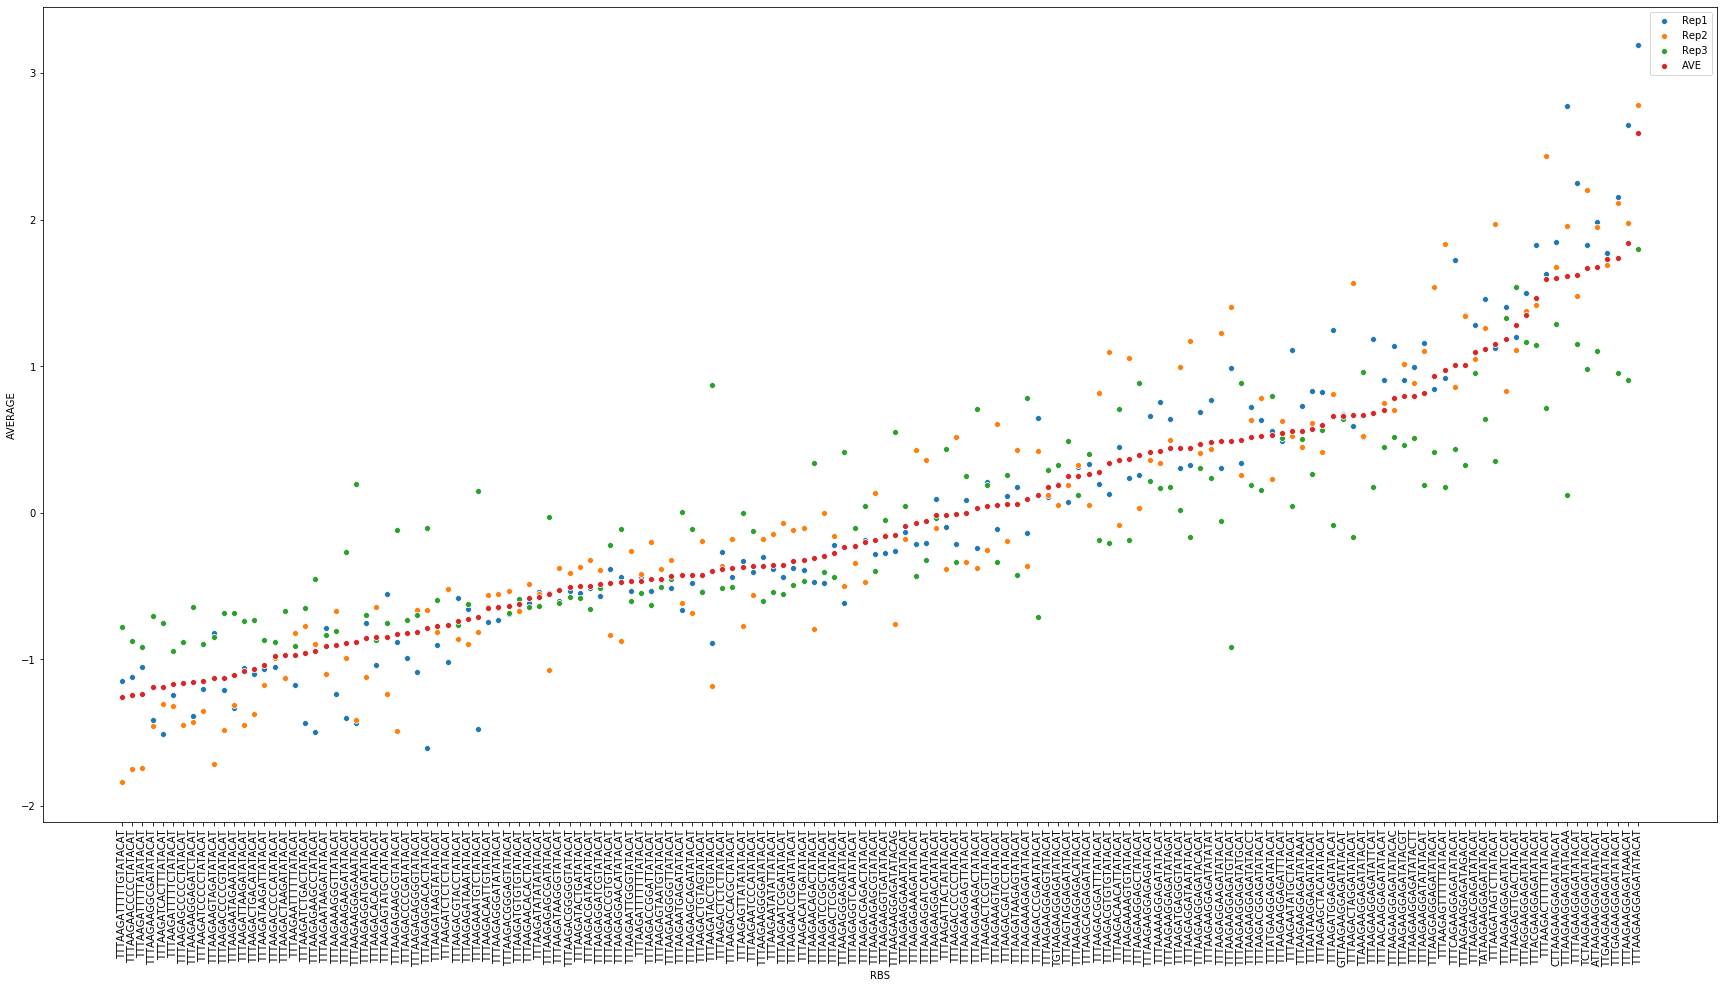

In [15]:
plt.figure(figsize = (30,15))
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep1'], label = 'Rep1')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep2'], label = 'Rep2')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep3'], label = 'Rep3')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['AVERAGE'], label = 'AVE')
labels = sorted_df['RBS']
ax.set_xticklabels(labels, rotation = 90)
plt.show()

In [ ]:
# fit curve

from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

plt.figure(figsize = (20,10))

color_list = ['blue', 'orange', 'green', 'red']
popt_dict = {}

for i, rep in enumerate(['Rep1', 'Rep2', 'Rep3', 'AVERAGE']):
    ydata = np.asarray(sorted_df[rep].dropna())
    xdata = range(len(ydata))
    popt, pcov = curve_fit(func, xdata, ydata)
    print(popt)
    popt_dict[rep] = popt
    plt.plot(xdata, func(xdata, *popt), label = rep, color = color_list[i])
    plt.plot(xdata, ydata)
    plt.legend()

In [ ]:
# normalise?

popt_dict

In [ ]:
df_normalised = sorted_df

for i, rep in enumerate(['Rep1', 'Rep2', 'Rep3', 'AVERAGE']):
    ratio = popt_dict[rep][0]/popt_dict['AVERAGE'][0]
    df_normalised[rep] = sorted_df[rep]/ratio
    normalised_rep = np.asarray(df_normalised[rep])
    
    xdata = range(len(normalised_rep))
    
    plt.plot(xdata, normalised_rep, label = rep, color = color_list[i])
    plt.legend()

In [ ]:
optimal_para, test_scores = cross_val(df_normalised, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag,
                                     l_lists, b_list, weight_flag, padding_flag, gap_flag)

Unfortunately, from the test error mean and std, normalise replicates seem to have little effect on the perforamcne. 

## Summary

To summarise, for the second round design, we choose to use all first round results (NO baseline data), with 
- Spectrum kennel
- alpha = 2
- lmer, l = [2,3,4,5,6]
- with replicates normalisation
- Sample mean as true label
- normalised kernel
- (TODO) features: no gap, np padding, no weight?